In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, 
                                   Flatten, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ReduceLROnPlateau, 
                                      EarlyStopping, 
                                      ModelCheckpoint)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Lambda
from tensorflow.keras.models import Model

In [17]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("TensorFlow is using GPU:", tf.test.is_gpu_available())

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
TensorFlow is using GPU: True


I0000 00:00:1750728216.014904      35 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750728216.015165      35 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Data Preparation

In [18]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Neutral',
    5: 'Sad',
    6: 'Surprise'
}

# Custom augmentation for Fear/Sad classes
weak_class_aug = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],
    fill_mode='reflect'
)

# Apply only to Fear(2), Sad(5), Disgust(1)
def augment_weak_classes(image, label):
    if np.argmax(label) in [1, 2, 5]:
        return weak_class_aug.random_transform(image)
    return image

# Enhanced data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=augment_weak_classes,  # ADD THIS
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9,1.1],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 64

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


# Build CNN Model

In [19]:
def build_high_acc_model():
    model = Sequential([
        # Block 1
        Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(48,48,1)),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),
        
        # Block 2
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.35),
        
        # Block 3
        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.45),

         # Add attention module before flattening
        Conv2D(512, (1,1), activation='relu'),
        BatchNormalization(),
        AttentionGate(),  # See implementation below
        
        # Classifier
        Flatten(),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),  # Increased dropout
        Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(0.01, 0.01)),
        Dense(7, activation='softmax')
    ])
    return model

# Attention Gate Implementation
def AttentionGate():
    def _attention_block(input_tensor):
        channels = input_tensor.shape[-1]
        x = Conv2D(channels//8, (1,1), activation='relu')(input_tensor)
        x = Conv2D(1, (1,1), activation='sigmoid')(x)
        return Multiply()([input_tensor, x])
    return _attention_block

model = build_high_acc_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,872,583 (22.40 MB)

 Trainable params: 5,869,767 (22.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

# Training Configuration

In [20]:
# Aggressive weighting for minority classes
class_weights = {
    0: 1.5,  # Angry
    1: 4.0,  # Disgust (4x weight)
    2: 3.0,  # Fear (3x weight)
    3: 0.8,  # Happy (reduce focus)
    4: 1.2,  # Neutral
    5: 2.5,  # Sad (2.5x weight)
    6: 1.0   # Surprise
}

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# Compile with learning rate decay
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training the model

In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 64s 136ms/step - accuracy: 0.1732 - loss: 10.0240 - val_accuracy: 0.0935 - val_loss: 3.5921 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.2086 - loss: 3.4249 - val_accuracy: 0.2775 - val_loss: 3.1041 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.2606 - loss: 3.0134 - val_accuracy: 0.2562 - val_loss: 2.8347 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.3415 - loss: 2.6936 - val_accuracy: 0.3315 - val_loss: 2.9113 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.3718 - loss: 2.6748 - val_accuracy: 0.3660 - val_loss: 2.7888 - learning_rate: 0.0010
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.4060 - loss: 2.6963 - val_accuracy: 0.4302 - val_loss: 2.6272 - learning_rate: 0.0010
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - accuracy: 0.4230 - loss

# Evaluation

In [22]:
model = tf.keras.models.load_model('best_model.h5')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.2%}")

Found 7178 images belonging to 7 classes.
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.6051 - loss: 1.2135

Test Accuracy: 63.71%


# Confusion Matrix

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step


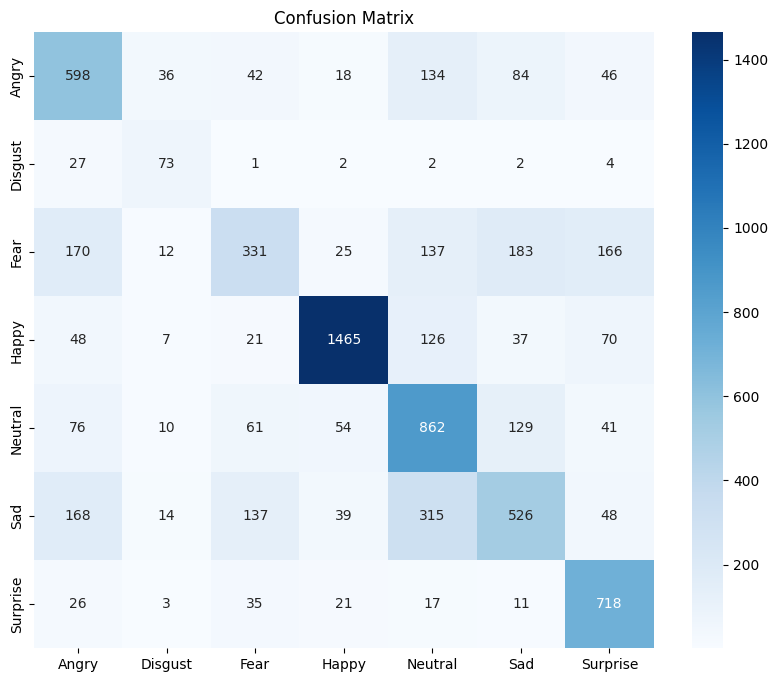

In [23]:
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_labels.values(), 
            yticklabels=emotion_labels.values())
plt.title('Confusion Matrix')
plt.show()

# Classification Report

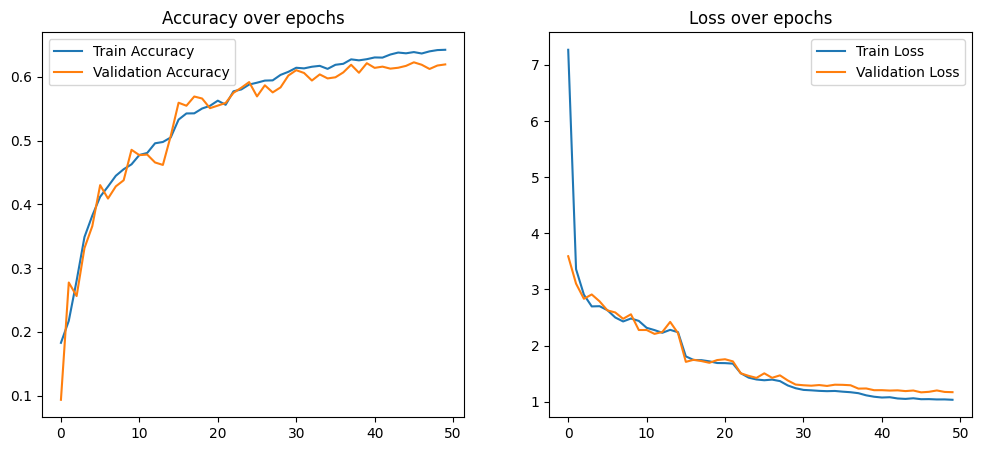

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()